In [1]:
"""
This script reads the .bio file and plots the acquired signal.


Copyright 2023 Mattia Orlandi, Pierangelo Maria Rapa

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

import struct
import sys

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from scipy.signal import butter, filtfilt
#define butter lowpass filter
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

# Define the bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

# Apply the bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, axis=0)
    return y

#apply the lowpass filter   
def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)  
    y = filtfilt(b, a, data, axis=0)
    return y
#define notch filter
def notch_filter(data, fs, f0, Q):
    nyq = 0.5 * fs
    low = f0 - (f0 / Q)
    high = f0 + (f0 / Q)
    b, a = butter(2, [low / nyq, high / nyq], btype='bandstop')
    y = filtfilt(b, a, data, axis=0)
    return y

def read_bio_file(file_path: str) -> dict:
    """
    Parameters
    ----------
    file_path : str
        Path to the .bio file.

    Returns
    -------
    dict
        Dictionary containing timestamp, signals and trigger.
    """
    dtypeMap = {
        "?": np.dtype("bool"),
        "b": np.dtype("int8"),
        "B": np.dtype("uint8"),
        "h": np.dtype("int16"),
        "H": np.dtype("uint16"),
        "i": np.dtype("int32"),
        "I": np.dtype("uint32"),
        "q": np.dtype("int64"),
        "Q": np.dtype("uint64"),
        "f": np.dtype("float32"),
        "d": np.dtype("float64"),
    }

    # Read data
    with open(file_path, "rb") as f:
        # Read number of signals
        n_signals = struct.unpack("<I", f.read(4))[0]

        # Read other metadata
        fs_base, n_samp_base = struct.unpack("<fI", f.read(8))
        signals = {}
        for _ in range(n_signals):
            sig_name_len = struct.unpack("<I", f.read(4))[0]
            sig_name = struct.unpack(f"<{sig_name_len}s", f.read(sig_name_len))[
                0
            ].decode()
            fs, n_samp, n_ch, dtype = struct.unpack("<f2Ic", f.read(13))
            dtype = dtypeMap[dtype.decode("ascii")]

            # Initialize signal array
            signals[sig_name] = {
                "fs": fs,
                "n_samp": n_samp,
                "n_ch": n_ch,
                "dtype": dtype,
            }

        # Read whether the trigger is available
        is_trigger = struct.unpack("<?", f.read(1))[0]

        # Read actual signals:
        # 1. Timestamp
        ts = np.frombuffer(f.read(8 * n_samp_base), dtype=np.float64).reshape(
            n_samp_base, 1
        )
        signals["timestamp"] = {"data": ts, "fs": fs_base}

        # 2. Signals data
        for sig_name, sig_data in signals.items():
            if sig_name == "timestamp":
                continue

            n_samp = sig_data.pop("n_samp")
            n_ch = sig_data.pop("n_ch")
            dtype = sig_data.pop("dtype")
            data = np.frombuffer(
                f.read(dtype.itemsize * n_samp * n_ch), dtype=dtype
            ).reshape(n_samp, n_ch)
            sig_data["data"] = data

        # 3. Trigger (optional)
        if is_trigger:
            trigger = np.frombuffer(f.read(), dtype=np.int32).reshape(n_samp_base, 1)
            signals["trigger"] = {"data": trigger, "fs": fs_base}

    return signals


In [ ]:
# read emg data and plot it with the trigger
emg_data = read_bio_file(r"C:\Users\pierangelo\Documents\silent_speech\acq_06_23\miguel\emg_8chs_monopolar_dome_double_2025-06-23_12-50-42.bio")
# Extract the EMG signal
emg_signal = emg_data["emg"]["data"]
battery = emg_data["battery"]["data"] if "battery" in emg_data else None
trigger = emg_data["trigger"]["data"]
ts_emg = emg_data["timestamp"]["data"].flatten()
# plot emg and trigger
start_ts = ts_emg[0] + 16
stop_ts = ts_emg[0] + 24

start_idx_emg = np.abs(ts_emg - start_ts).argmin(axis=0).item()
stop_idx_emg = np.abs(ts_emg - stop_ts).argmin(axis=0).item()


ts_emg = ts_emg[start_idx_emg:stop_idx_emg]
# ts_audio = ts_audio[start_idx_audio:stop_idx_audio]

emg_signal = emg_signal[start_idx_emg*200:stop_idx_emg*200, :]
trigger = trigger[start_idx_emg:stop_idx_emg, :]
# plot emg enad trigger create t_emg and t_trigger using linspace
t_emg = np.linspace(start_ts-start_ts, stop_ts-start_ts, emg_signal.shape[0])
t_trigger = np.linspace(start_ts-start_ts, stop_ts-start_ts, trigger.shape[0])

#apply bandpass filter to emg signal
emg_signal = bandpass_filter(emg_signal, 20, 300, emg_data["emg"]["fs"], order=4)
#aply notch filter to emg signal
emg_signal = notch_filter(emg_signal, emg_data["emg"]["fs"], 60, 30)
emg_signal = notch_filter(emg_signal, emg_data["emg"]["fs"], 120, 30)
emg_signal = emg_signal*3/12*1000

channels_name = ["E1", "E2", "E3", "E4", "E5", "E6", "E7", "E8"]
y_lim = (-250, 250)
# hide the legend

# Plot EMG signal plot ache channel in a different subplot and the trigger in the last subplot
# use seaborn and make the plot nicer 
plt.figure(figsize=(12, 18))
for i in range(emg_signal.shape[1]):
    plt.subplot(emg_signal.shape[1]+1, 1, i + 1)
    sns.lineplot(x=t_emg, y=emg_signal[:, i], label=f"Channel {channels_name[i]}", legend=False)
    plt.title(f"Channel {channels_name[i]}")
    # plt.xlabel("Time (s)")
    plt.ylabel("Amplitude [µV]")
    plt.ylim(y_lim)
    plt.grid()
    # plt.legend()
    plt.tight_layout()

# Plot trigger signal
# put some text  on top of the trigger signal when is one or two

plt.subplot(emg_signal.shape[1]+1, 1, emg_signal.shape[1]+1)
sns.lineplot(x=t_trigger, y=trigger.flatten(), label="Trigger", color="red", legend=False)
plt.title("Trigger Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
# plt.legend()
plt.ylim(0, 4)
if np.any(trigger == 1):
    plt.text(t_trigger[trigger.flatten() == 1][0], 1.1, "ALFA", color="red", fontsize=18, ha='center')
if np.any(trigger == 2):
    plt.text(t_trigger[trigger.flatten() == 2][0], 2.1, "BRAVO", color="blue", fontsize=18, ha='center')
plt.tight_layout()
plt.show()


In [ ]:
battery

In [ ]:
#compute the spectrogram of the first channel and chose nperseg based on the sampling frequency
nperseg = int(emg_data["emg"]["fs"] / 10)  # 100 ms window
from scipy.signal import spectrogram
f, t, Sxx = spectrogram(emg_signal[:, 0], fs=emg_data["emg"]["fs"], nperseg=nperseg)
plt.figure(figsize=(12, 6))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.colorbar(label='Intensity [dB]')
plt.title('Spectrogram of EMG Signal (Channel 1)')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.ylim(0, 300)  # Limit frequency to 150 Hz
plt.tight_layout()
plt.show()

In [ ]:
# compute the maximum peak to peak amplitude for each channel
max_peak_to_peak = np.max(emg_signal, axis=0) - np.min(emg_signal, axis=0)
# print the maximum peak to peak amplitude for each channel
for i, channel in enumerate(channels_name):
    print(f"Maximum peak-to-peak amplitude for channel {channel}: {max_peak_to_peak[i]:.2f} µV")
# compute the mean and std of the signal for each channel
mean_signal = np.mean(emg_signal, axis=0)
std_signal = np.std(emg_signal, axis=0)
# print the mean and std of the signal for each channel
for i, channel in enumerate(channels_name):
    print(f"Mean amplitude for channel {channel}: {mean_signal[i]:.2f} µV")
    print(f"Standard deviation for channel {channel}: {std_signal[i]:.2f} µV")
# compute the mean peak to peak over channels
mean_peak_to_peak = np.mean(max_peak_to_peak)
print(f"Mean peak-to-peak amplitude over channels: {mean_peak_to_peak:.2f} µV")


In [ ]:
np.argmax(emg_signal, axis=0) /emg_data["emg"]["fs"] 

In [ ]:
emg_signal.shape[0] / emg_data["emg"]["fs"]  # duration of the signal in seconds

In [ ]:
#compute mean and std only for sEmg portion that shows activity, fin the activiy using the enrgy of the signal
energy_signal = np.sum(emg_signal**2, axis=1)
# find the indices where the energy is above a threshold
threshold = np.mean(energy_signal) + 2 * np.std(energy_signal)
active_indices = np.where(energy_signal > threshold)[0]
# compute the mean and std only for the active portion of the signal
mean_active_signal = np.mean(emg_signal[active_indices, :], axis=0)
std_active_signal = np.std(emg_signal[active_indices, :], axis=0)
# print the mean and std of the active signal for each channel
for i, channel in enumerate(channels_name):
    print(f"Mean amplitude for active channel {channel}: {mean_active_signal[i]:.2f} µV")
    print(f"Standard deviation for active channel {channel}: {std_active_signal[i]:.2f} µV")
# compute the peak-to-peak amplitude for the active portion of the signal
active_peak_to_peak = np.max(emg_signal[active_indices, :], axis=0) - np.min(emg_signal[active_indices, :], axis=0)
# print the peak-to-peak amplitude for the active portion of the signal
for i, channel in enumerate(channels_name):
    print(f"Peak-to-peak amplitude for active channel {channel}: {active_peak_to_peak[i]:.2f} µV")
#comute mean standard deviation and peak to peak amplitude for the active portion of the signal
mean_active_peak_to_peak = np.mean(active_peak_to_peak)
print(f"Mean peak-to-peak amplitude for active portion of the signal: {mean_active_peak_to_peak:.2f} µV")
mean_std_active_signal = np.mean(std_active_signal)
print(f"Mean standard deviation for active portion of the signal: {mean_std_active_signal:.2f} µV")

In [ ]:
#compute mean and std only for sEmg portion that shows activity, fin the activiy using the enrgy of the signal
emg_energy = np.sum(emg_signal**2, axis=1)
activity_threshold = np.percentile(emg_energy, 95)
active_emg = emg_signal[emg_energy > activity_threshold]
mean_active_emg = np.mean(active_emg, axis=0)
std_active_emg = np.std(active_emg, axis=0)
# compute the active peak to peak amplitude using max and min trimmed to 95% percentile
active_peak_to_peak_emg = np.max(active_emg, axis=0) - np.min(active_emg, axis=0)
# print the mean and std of the active emg signal for each channel


In [ ]:
lower = np.percentile(active_emg, 2.5, axis=0)
upper = np.percentile(active_emg, 97.5, axis=0)
active_peak_to_peak_trimmed = upper - lower
for i, channel in enumerate(channels_name):
    print(f"Trimmed (95%) peak-to-peak amplitude for active channel {channel}: {active_peak_to_peak_trimmed[i]:.2f} µV")

In [ ]:
#compute signal to noise ratio for each channel considering noise the non active portion of the signal
snr = mean_active_signal / std_signal
for i, channel in enumerate(channels_name):
    print(f"Channel {channel}: SNR = {snr[i]:.2f} dB")
# compute the mean and std of the signal for each channel
mean_signal = np.mean(emg_signal, axis=0)
std_signal = np.std(emg_signal, axis=0)

In [ ]:
# Plot the EMG signal for each channel use active_indices to highlight the active portion of the signal
plt.figure(figsize=(12, 10))
for i in range(emg_signal.shape[1]):
    plt.subplot(emg_signal.shape[1]+1, 1, i + 1)
    sns.lineplot(x=t_emg, y=emg_signal[:, i], label=f"Channel {channels_name[i]}")
    sns.scatterplot(x=t_emg[active_indices], y=emg_signal[active_indices, i], color='red', label='Active Portion')
    plt.title(f"Channel {channels_name[i]}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude [µV]")
    plt.grid()
    plt.legend()
    plt.tight_layout()


In [ ]:
# Plot EMG signal plot ache channel in a different subplot and the trigger in the last subplot
# use seaborn and poster style
plt.figure(figsize=(12, 10))
for i in range(emg_signal.shape[1]):
    plt.subplot(emg_signal.shape[1]+1, 1, i + 1)
    sns.lineplot(x=t_emg, y=emg_signal[:, i], label=f"Channel {i + 1}")
    plt.title(f"EMG Channel {i + 1}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.grid()
    plt.legend()
    plt.tight_layout()
# Plot trigger signal
plt.subplot(emg_signal.shape[1]+1, 1, emg_signal.shape[1]+1)
sns.lineplot(x=t_trigger, y=trigger.flatten(), label="Trigger", color="red")
plt.title("Trigger Signal")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
emg_data = read_bio_file(r"C:\Users\pierangelo\Documents\silent_speech\acq_06_25\miguel\emg_8chs_flex_e9_2025-06-25_15-34-33.bio")
# Extract the EMG signal
emg_signal = emg_data["emg"]["data"]
battery = emg_data["battery"]["data"] if "battery" in emg_data else None

audio_data = read_bio_file(r"C:\Users\pierangelo\Documents\silent_speech\acq_06_25\miguel\audio_8chs_flex_e9_2025-06-25_15-34-33.bio")
trigger = audio_data["trigger"]["data"] if "trigger" in audio_data else None
audio_signal = audio_data["audio"]["data"]
ts_audio = audio_data["timestamp"]["data"]
ts_emg = emg_data["ts"]["data"].astype(np.float64)/1_000_000
# Compute the difference in number of samples between audio and emg and align the signals to make them the same length, the two signals have different frequencies
# use frequncy of audio signal to align the two signals
# diff_time = audio_signal.shape[0] / audio_data["audio"]["fs"] - emg_signal.shape[0] / emg_data["emg"]["fs"] 
# diff_samples = int(diff_time * audio_data["audio"]["fs"])
# audio_signal = audio_signal[diff_samples:]
start_ts = ts_emg[0] + 4
stop_ts = ts_emg[0]  + 60

start_idx_emg = np.abs(ts_emg - start_ts).argmin(axis=0).item()
start_idx_audio = np.abs(ts_audio - start_ts).argmin(axis=0).item()
stop_idx_emg = np.abs(ts_emg - stop_ts).argmin(axis=0).item()
stop_idx_audio = np.abs(ts_audio - stop_ts).argmin(axis=0).item()

# ts_emg = ts_emg[start_idx_emg:stop_idx_emg]
# # ts_audio = ts_audio[start_idx_audio:stop_idx_audio]

emg_signal = emg_signal[start_idx_emg*5:stop_idx_emg*5, :]
audio_signal = audio_signal[start_idx_audio*960:stop_idx_audio*960, :]
trigger = trigger[int(start_idx_audio):int(stop_idx_audio)] 


#apply bandpass filter to emg signal
emg_signal = bandpass_filter(emg_signal, 20, 450, emg_data["emg"]["fs"], order=4)
#aply notch filter to emg signal
emg_signal = notch_filter(emg_signal, emg_data["emg"]["fs"], 60, 30)*1000
emg_signal = emg_signal*3/12





In [ ]:
#create t_emg and t_audio vectors using linspace    
t_emg = np.linspace(start_ts - start_ts, stop_ts - start_ts, emg_signal.shape[0])
t_audio = np.linspace(start_ts - start_ts, stop_ts - start_ts, audio_signal.shape[0])
t_trigger = np.linspace(start_ts - start_ts, stop_ts - start_ts, trigger.shape[0])
#create t_emg and t_audio vectors using np arange, do no tuse ts
# t_emg = np.arange(0, emg_signal.shape[0] / emg_data["emg"]["fs"], 1 / emg_data["emg"]["fs"])
# t_audio = np.arange(0, audio_signal.shape[0] / audio_data["audio"]["fs"], 1 / audio_data["audio"]["fs"])
min_amplitude = -250
max_amplitude = 250

#plot the emg signal and audio signal using subplots, separate the two emg channels in tow subplots and the audio signal in a third subplot
plt.rcParams.update({'font.size': 14})  # Set default font size for plots
plt.figure(figsize=(12, 6))
plt.subplot(4, 1, 1)
plt.plot(t_emg, emg_signal[:, 0], label='EMG Channel 1')
plt.title('EMG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
#add ylim to the plot
# plt.ylim(min_amplitude, max_amplitude)
# plt.legend()
plt.subplot(4, 1, 2)
plt.plot(t_emg, emg_signal[:, 1], label='EMG Channel 2')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
# plt.ylim(min_amplitude, max_amplitude)
# plt.legend()
plt.title('EMG Signal - Channel 2')

plt.subplot(4, 1, 3)
plt.plot(t_audio, audio_signal[:, 0], label='Audio Signal')
plt.title('Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
# plt.legend()
plt.tight_layout()

plt.subplot(4, 1, 4)
plt.plot(t_trigger, trigger, label='Trigger Signal')
plt.title('Trigger Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
# plt.legend()

plt.show()


In [ ]:
#move each audio data 100 ms backward in time and pad the end with zeros
def pad_audio_data(audio_data, sr, pad_time=0.1):
    """
    Pad the audio data with zeros at the end.
    :param audio_data: Audio time series.
    :param sr: Sample rate.
    :param pad_time: Time to pad in seconds.
    :return: Padded audio data.
    """
    pad_length = int(pad_time * sr)
    padded_audio = np.pad(audio_data, (0, pad_length), mode='constant')
    return padded_audio

def move_audio_data_backward(audio_data, sr, move_time=0.1):
    """
    Move the audio data backward in time.
    :param audio_data: Audio time series.
    :param sr: Sample rate.
    :param move_time: Time to move backward in seconds.
    :return: Moved audio data.
    """
    move_length = int(move_time * sr)
    moved_audio = np.roll(audio_data, -move_length)
    moved_audio[-move_length:] = 0  # Set the last 'move_length' samples to zero
    return moved_audio

In [2]:
emg_data = read_bio_file(r"C:\Users\pierangelo\Documents\silent_speech\acq_07_08\emg_diff_8chs_silent_2025-07-08_17-13-20.bio")
# Extract the EMG signal
emg_signal = emg_data["emg"]["data"]
battery = emg_data["battery"]["data"] if "battery" in emg_data else None

audio_data = read_bio_file(r"C:\Users\pierangelo\Documents\silent_speech\acq_07_08\audio_diff_8chs_silent_2025-07-08_17-13-21.bio")
trigger = audio_data["trigger"]["data"] if "trigger" in audio_data else None
audio_signal = audio_data["audio"]["data"]
ts_audio = audio_data["timestamp"]["data"]
ts_emg = emg_data["ts"]["data"].astype(np.float64)/1_000_000
ts_emg = emg_data["timestamp"]["data"]
#apply bandpass filter to emg signal
# emg_signal = bandpass_filter(emg_signal, 20, 500, emg_data["emg"]["fs"], order=4)
#aply notch filter to emg signal
# emg_signal = notch_filter(emg_signal, emg_data["emg"]["fs"], 60, 30)
emg_signal = emg_signal*1000*3/12

In [3]:
audio_signal = audio_signal[int(0.16*audio_data["audio"]["fs"]):]



In [22]:
#use the trigger signal to separate each utterance in the audio signal and plot them separately
# crete a list of unique values of triggers
trigger_values = []
utterances_audio = []
utterances_emg = []
trigger_change = np.where(np.diff(trigger.flatten()) != 0)[0] + 1
#iterate over trigger change dimensione in step of 2
for i in range(0, len(trigger_change[:-1]), 2):
    start = trigger_change[i] 
    end = trigger_change[i + 1]
    start_ts = ts_audio[start] -0.5
    stop_ts = ts_audio[end] 
    start_idx_emg = np.abs(ts_emg - start_ts).argmin(axis=0).item()
    start_idx_audio = np.abs(ts_audio - start_ts).argmin(axis=0).item()
    stop_idx_emg = np.abs(ts_emg - stop_ts).argmin(axis=0).item()
    stop_idx_audio = np.abs(ts_audio - stop_ts).argmin(axis=0).item()
    start_idx_trigger = np.abs(ts_audio - start_ts).argmin(axis=0).item()
    stop_idx_trigger = np.abs(ts_audio - stop_ts).argmin(axis=0).item()
    trigger_values.append(np.unique(trigger[start_idx_trigger:stop_idx_trigger])[-1])
    utterances_audio.append(audio_signal[start_idx_audio*960:stop_idx_audio*960])
    print(start_idx_emg, stop_idx_emg)
    utterances_emg.append(emg_signal[start_idx_emg*200:stop_idx_emg*200])
    

29 64
68 103
109 143
148 183
188 223
228 263
268 303
308 343
348 383
388 423
428 463
468 502
508 541
547 581
586 621
626 661
666 701
706 741
746 781
786 821
826 861
866 901
906 940
946 980
985 1020
1025 1060
1065 1100
1105 1140
1145 1180
1185 1220
1225 1260
1265 1300
1305 1340
1345 1380
1385 1420
1424 1459
1464 1499
1504 1539
1544 1580
1585 1620
1625 1660
1664 1699
1704 1739
1744 1779
1784 1818
1824 1858
1862 1896
1902 1937
1942 1977
1982 2017
2022 2057
2062 2097
2102 2137
2142 2177
2182 2217
2222 2257
2262 2297
2303 2337
2342 2377
2382 2418
2422 2457
2462 2497
2502 2537
2542 2577
2582 2617
2622 2657
2662 2697
2702 2737
2742 2776
2782 2816
2821 2856
2861 2896
2901 2936
2941 2976
2981 3016
3021 3055
3060 3095
3100 3136
3141 3174
3179 3214
3219 3254
3259 3294
3299 3334
3339 3374
3379 3413
3419 3453
3458 3493
3498 3533
3538 3573
3578 3613
3618 3653
3658 3693
3698 3733
3738 3773
3778 3812
3817 3853
3857 3892
3897 3932
3937 3972
3977 4012
4017 4052
4057 4092
4096 4131
4136 4171
4176 4211
42

In [10]:
len(trigger_change)

1040

In [12]:
20*26*2

1040

In [28]:
#use the trigger signal to separate each utterance in the audio signal and plot them separately
# crete a list of unique values of triggers
trigger_values = []
utterances_audio = []
utterances_emg = []
trigger_change = np.where(np.diff(trigger.flatten()) != 0)[0] + 1
#iterate over trigger change dimensione in step of 2
for i in range(0, len(trigger_change[:-1]), 2):
    # print(i//2)
    if (i//2)%2 == 0:
        start_emg = trigger_change[i]
        end_emg = trigger_change[i + 1]
        start_ts_emg = ts_audio[start_emg] - 0.5
        stop_ts_emg = ts_audio[end_emg]
        start_audio = trigger_change[i] 
        end_audio = trigger_change[i + 1]
        # print(start_audio, end_audio)

        start_ts_audio = ts_audio[start_audio] -0.5
        stop_ts_audio = ts_audio[end_audio] 
    else:
        start_emg = trigger_change[i]
        end_emg = trigger_change[i+1]
        start_ts_emg = ts_audio[start_emg] - 0.5
        stop_ts_emg = ts_audio[end_emg]
        start_audio = trigger_change[i - 2] 
        end_audio = trigger_change[i-1]
        start_ts_audio = ts_audio[start_audio] -0.5
        stop_ts_audio = ts_audio[end_audio]

    start_idx_emg = np.abs(ts_emg - start_ts_emg).argmin(axis=0).item()
    start_idx_audio = np.abs(ts_audio - start_ts_audio).argmin(axis=0).item()
    stop_idx_emg = np.abs(ts_emg - stop_ts_emg).argmin(axis=0).item()
    stop_idx_audio = np.abs(ts_audio - stop_ts_audio).argmin(axis=0).item()
    start_idx_trigger = np.abs(ts_audio - start_ts_emg).argmin(axis=0).item()
    stop_idx_trigger = np.abs(ts_audio - stop_ts_emg).argmin(axis=0).item()
    trigger_values.append(np.unique(trigger[start_idx_trigger:stop_idx_trigger])[-1])
    utterances_audio.append(audio_signal[start_idx_audio*960:stop_idx_audio*960])
    print(start_idx_emg, stop_idx_emg)
    print(start_idx_audio, stop_idx_audio)
    utterances_emg.append(emg_signal[start_idx_emg*200:stop_idx_emg*200])
    

29 64
487 661
68 103
487 661
109 144
887 1062
149 184
887 1062
189 223
1287 1462
228 263
1287 1462
268 303
1687 1862
308 343
1687 1862
348 383
2088 2263
388 423
2088 2263
428 463
2489 2663
468 503
2489 2663
508 543
2888 3063
548 583
2888 3063
588 623
3288 3462
628 663
3288 3462
668 703
3686 3862
708 742
3686 3862
747 782
4088 4262
787 823
4088 4262
827 862
4488 4664
867 902
4488 4664
907 942
4889 5059
947 982
4889 5059
987 1022
5284 5459
1027 1062
5284 5459
1067 1102
5684 5859
1107 1142
5684 5859
1147 1181
6083 6259
1187 1221
6083 6259
1226 1261
6485 6659
1266 1301
6485 6659
1306 1340
6886 7059
1345 1381
6886 7059
1386 1420
7285 7459
1425 1461
7285 7459
1466 1500
7685 7859
1505 1540
7685 7859
1545 1580
8080 8256
1584 1620
8080 8256
1625 1660
8480 8655
1665 1700
8480 8655
1705 1739
8880 9055
1744 1779
8880 9055
1784 1819
9280 9455
1824 1859
9280 9455
1864 1899
9680 9855
1904 1939
9680 9855
1944 1979
10080 10255
1984 2018
10080 10255
2023 2059
10480 10655
2063 2098
10480 10655
2103 2138


In [ ]:
trigger_values

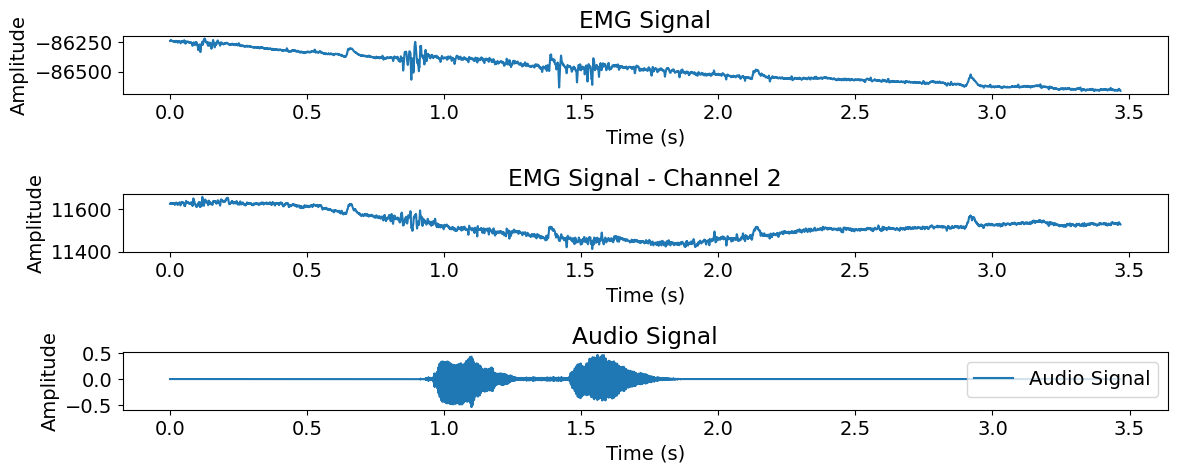

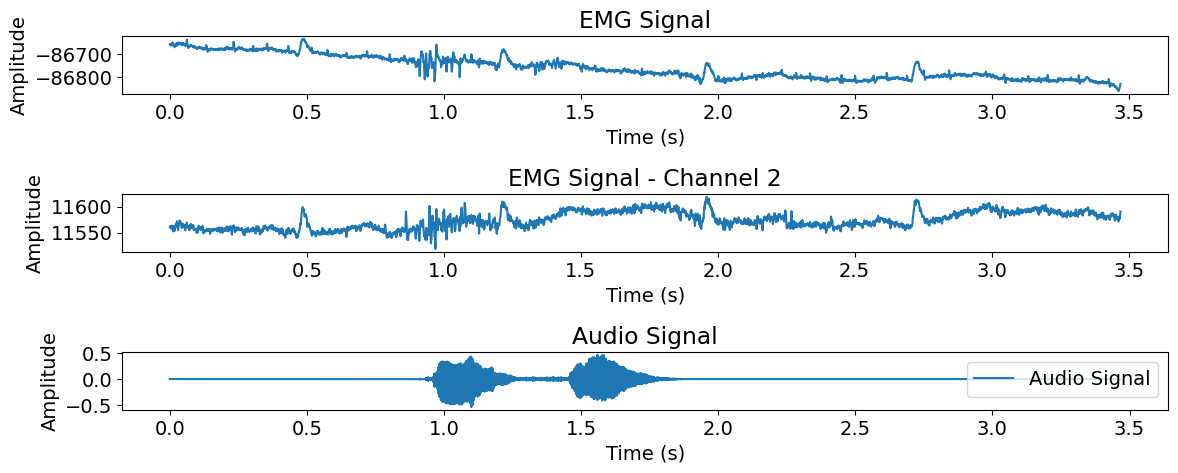

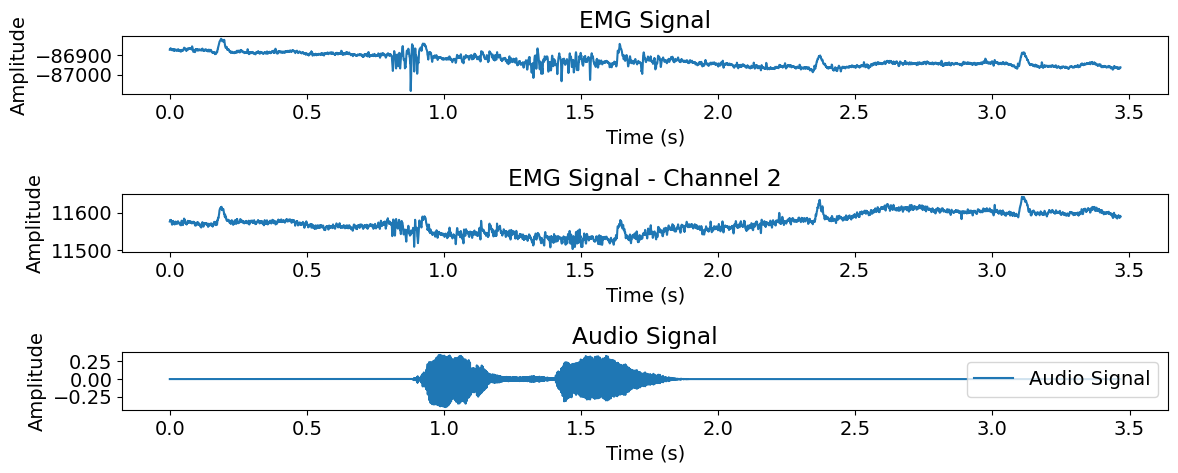

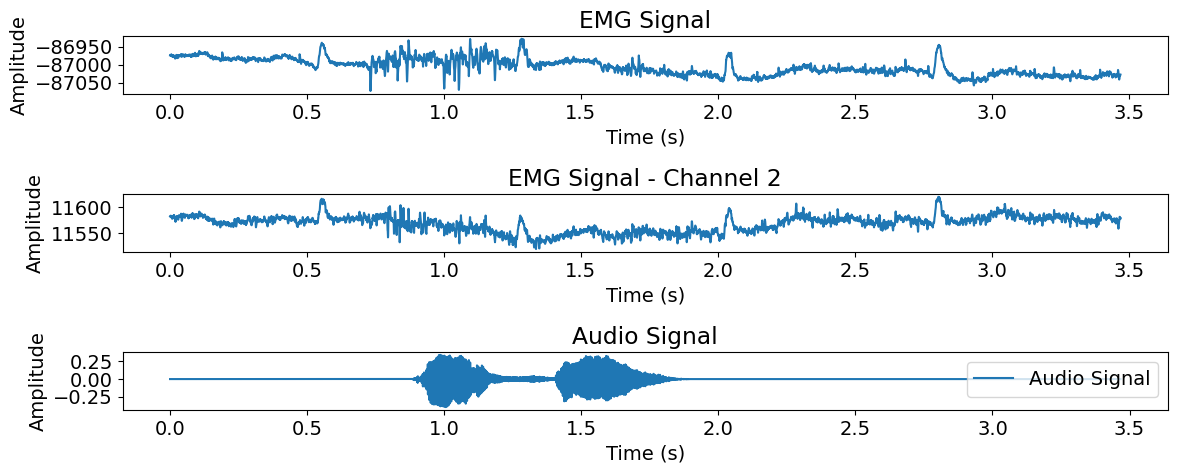

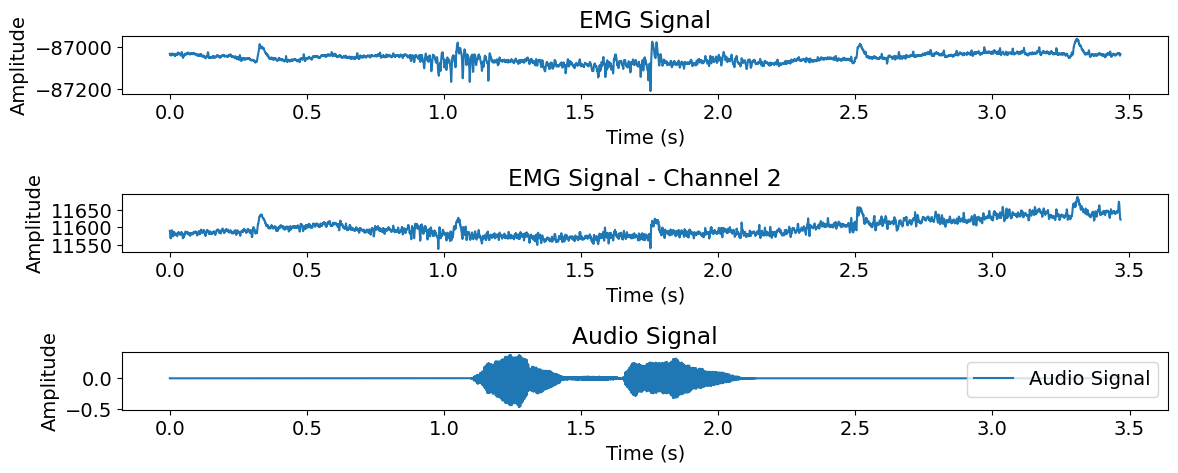

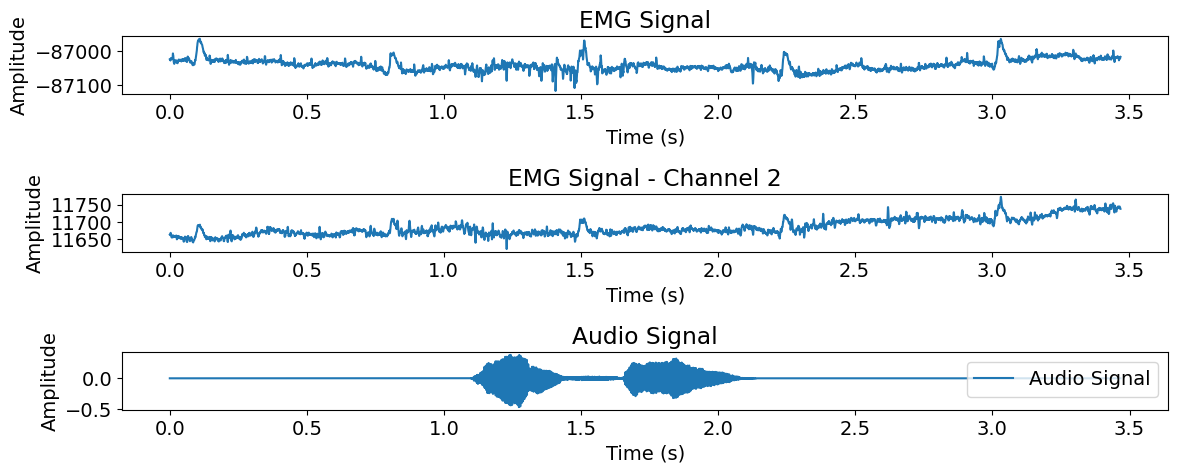

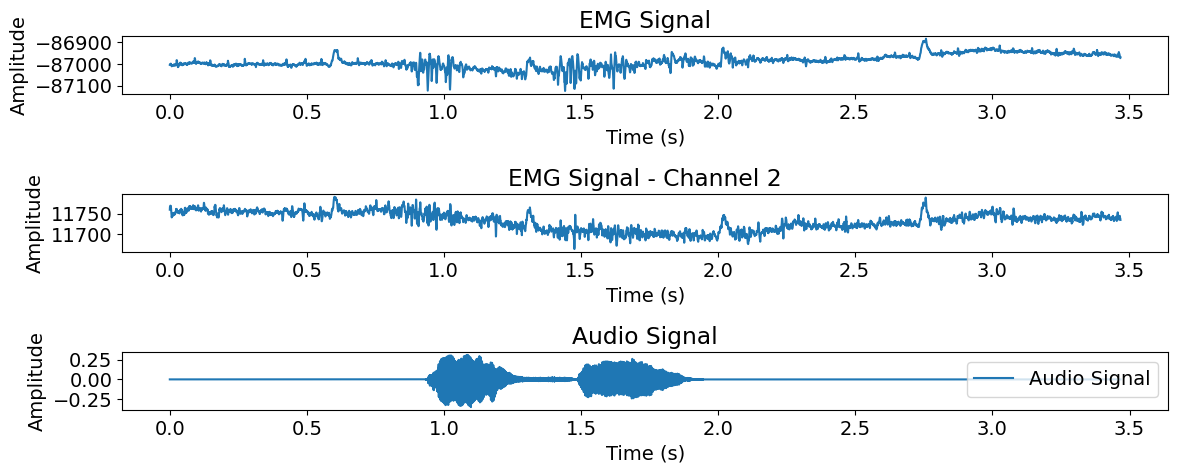

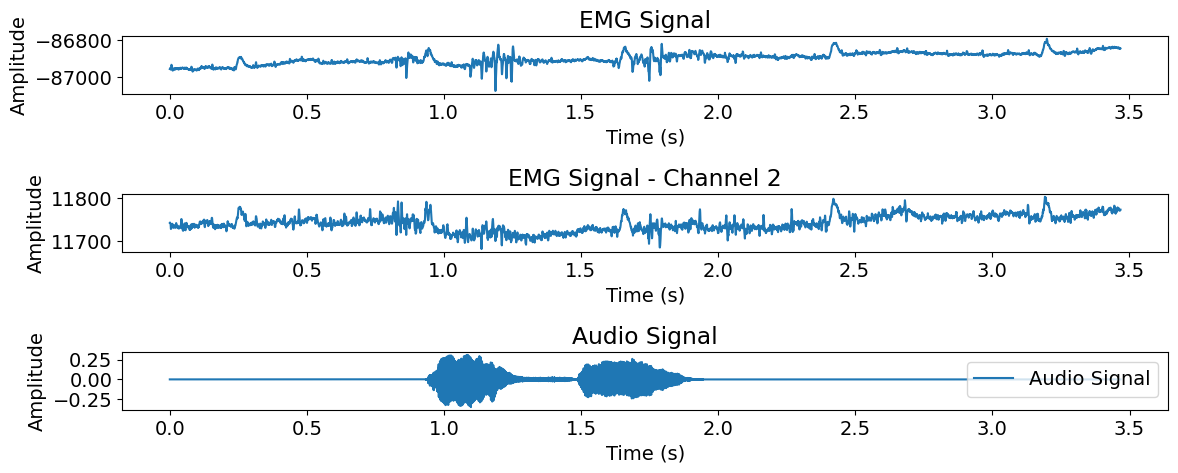

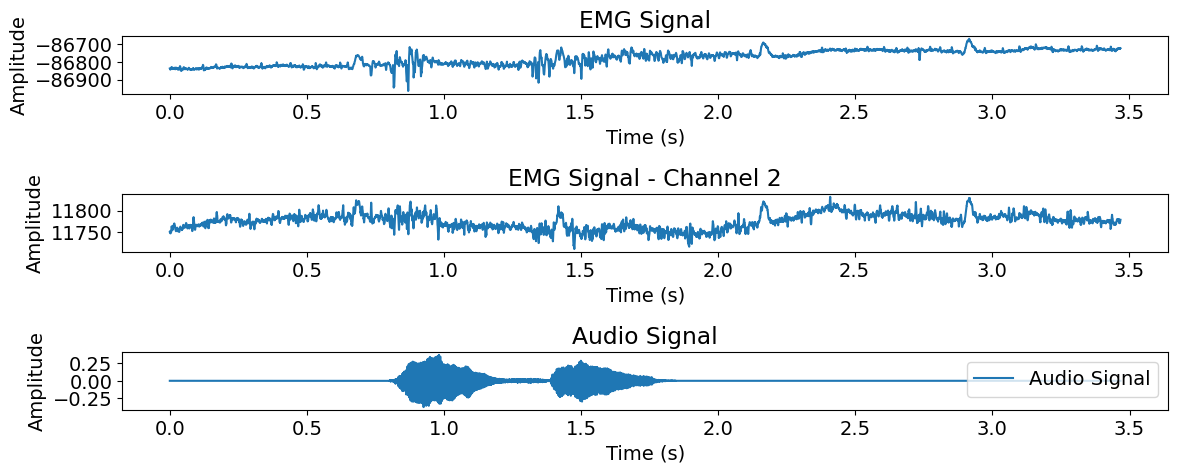

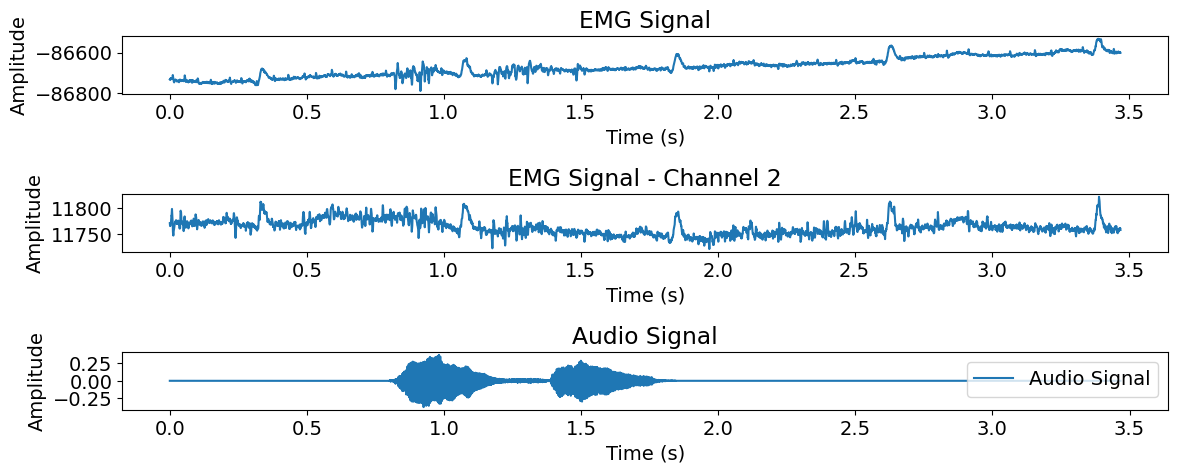

In [34]:
for i in range(len(utterances_audio[:10])):
    #create t_emg and t_audio vectors using linspace    
    t_emg = np.linspace(start_ts_emg - start_ts_emg, stop_ts_emg - start_ts_emg, utterances_emg[i].shape[0])
    t_audio = np.linspace(start_ts_audio - start_ts_audio, stop_ts_audio - start_ts_audio, utterances_audio[i].shape[0])
    # t_trigger = np.linspace(start_ts - start_ts, stop_ts - start_ts, trigger.shape[0])
    #create t_emg and t_audio vectors using np arange, do no tuse ts
    # t_emg = np.arange(0, emg_signal.shape[0] / emg_data["emg"]["fs"], 1 / emg_data["emg"]["fs"])
    # t_audio = np.arange(0, audio_signal.shape[0] / audio_data["audio"]["fs"], 1 / audio_data["audio"]["fs"])
    min_amplitude = -100
    max_amplitude = 100
    #plot the emg signal and audio signal using subplots, separate the two emg channels in tow subplots and the audio signal in a third subplot
    plt.rcParams.update({'font.size': 14})  # Set default font size for plots
    plt.figure(figsize=(12, 6))
    plt.subplot(4, 1, 1)
    plt.plot(t_emg, utterances_emg[i][:, 4], label='EMG Channel 1')
    plt.title('EMG Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    #add ylim to the plot
    # plt.ylim(min_amplitude, max_amplitude)
    # plt.legend()
    plt.subplot(4, 1, 2)
    plt.plot(t_emg, utterances_emg[i][:, 5], label='EMG Channel 2')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    # plt.ylim(min_amplitude, max_amplitude)
    # plt.legend()
    plt.title('EMG Signal - Channel 2')

    plt.subplot(4, 1, 3)
    plt.plot(t_audio, utterances_audio[i][:, 0], label='Audio Signal')
    plt.title('Audio Signal')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()

    # plt.subplot(4, 1, 4)
    # plt.plot(t_trigger, trigger, label='Trigger Signal')
    # plt.title('Trigger Signal')
    # plt.xlabel('Time (s)')
    # plt.ylabel('Amplitude')
    # # plt.legend()

    plt.show()

In [ ]:
# write the function to write wav you can use scipy.io.wavfile.write
from scipy.io import wavfile
def write_wav(filename: str, data: np.ndarray, fs: float):
    """
    Write a WAV file.

    Parameters
    ----------
    filename : str
        The name of the file to write.
    data : np.ndarray
        The audio data to write.
    fs : float
        The sampling frequency of the audio data.
    """
    wavfile.write(filename, int(fs), data.astype(np.float32))


In [32]:
# use librosa to write the audio signal to a wav file using soundfile backend
import soundfile as sf
def write_wav_librosa(filename: str, data: np.ndarray, fs: float):
    """
    Write a WAV file using librosa.

    Parameters
    ----------
    filename : str
        The name of the file to write.
    data : np.ndarray
        The audio data to write.
    fs : float
        The sampling frequency of the audio data.
    """
    y =  (data * 32767).astype('int16')
    sf.write(filename, y, int(fs), format='WAV')

In [33]:
import os
#create a list with the nato alphabet up to delta
nato_alphabet = [
    "Alfa",
    "Bravo",
    "Charlie",
    "Delta",
    "Echo",
    "Foxtrot",
    "Golf",
    "Hotel",
    "India",
    "Juliett",
    "Kilo",
    "Lima",
    "Mike",
    "November",
    "Oscar",
    "Papa",
    "Quebec",
    "Romeo",
    "Sierra",
    "Tango",
    "Uniform",
    "Victor",
    "Whiskey",
    "Xray",
    "Yankee",
    "Zulu"
    
]
# create a dictionary to map the trigger values to the nato alphabet
trigger_map = {i + 1: nato_alphabet[i] for i in range(len(nato_alphabet))}
# save the emg in a npy file, save a file for each utterance, some utterances trigger values are the same so put a number at the end of the file name
#put a number after name on the same values inside trigger_values, the number should restart from 1 for each value, create the file if not exists
path = f"C:/Users/pierangelo/Documents/silent_speech/modified/full_nato_10reps_diff_silent_grace"
if not os.path.exists(f"{path}/audio"):
    os.makedirs(f"{path}/audio")
if not os.path.exists(f"{path}/emg"):
    os.makedirs(f"{path}/emg")
num_file = 1
for i, trigger_value in enumerate(np.unique(trigger_values)):
    num_file = 1
    for j in range(len(trigger_values)):
        if trigger_values[j] == trigger_value:
            write_wav_librosa(f"{path}/audio/{trigger_map[trigger_values[j]]}_{num_file}.wav", utterances_audio[j][:,0], 48000)
            np.save(f"{path}/emg/{trigger_map[trigger_values[j]]}_{num_file}.npy", utterances_emg[j])
            num_file += 1

In [ ]:
import os
#create a list with the nato alphabet up to delta
nato_alphabet = [
    "Alfa",
    "Bravo"
    
]
# create a dictionary to map the trigger values to the nato alphabet
trigger_map = {i + 1: nato_alphabet[i] for i in range(len(nato_alphabet))}
# save the emg in a npy file, save a file for each utterance, some utterances trigger values are the same so put a number at the end of the file name
#put a number after name on the same values inside trigger_values, the number should restart from 1 for each value, create the file if not exists
path = f"C:/Users/pierangelo/Documents/silent_speech/alfa_bravo_4reps_diff_ref_pierangelo"
if not os.path.exists(f"{path}/audio"):
    os.makedirs(f"{path}/audio")
if not os.path.exists(f"{path}/emg"):
    os.makedirs(f"{path}/emg")
num_file = 1
for i, trigger_value in enumerate(np.unique(trigger_values)):
    num_file = 1
    for j in range(len(trigger_values)):
        if trigger_values[j] == trigger_value:
            write_wav_librosa(f"{path}/audio/{trigger_map[trigger_values[j]]}_{num_file}.wav", utterances_audio[j][:,0], 48000)
            np.save(f"{path}/emg/{trigger_map[trigger_values[j]]}_{num_file}.npy", utterances_emg[j])
            num_file += 1

In [ ]:
utterances_emg[j].shape

In [ ]:
NCH_EMG = emg_signal.shape[1]
#remove channel 1 from the emg signal



for i in range(len(utterances_audio)):
    #create t_emg and t_audio vectors using linspace    
    t_emg = np.linspace(start_ts - start_ts, stop_ts - start_ts, utterances_emg[i].shape[0])
    t_audio = np.linspace(start_ts - start_ts, stop_ts - start_ts, utterances_audio[i].shape[0])
    #go over the channels of emg and create a single plot for each channel then one subplot for the audio signal
    min_amplitude = -250
    max_amplitude = 250
    plt.figure(figsize=(12, 10))
    for ch in range(NCH_EMG):
        plt.subplot(NCH_EMG + 1 , 1, ch + 1)
        if ch < 4:
            plt.plot(t_emg, utterances_emg[i][:, ch], label=f"ear piece Channel {ch + 1}")
        else:
            plt.plot(t_emg, utterances_emg[i][:, ch], label=f"Neckband Channel {ch + 1 - 4}")
        # plt.ylim(min_amplitude, max_amplitude)
        plt.legend(loc="upper right")
    plt.subplot(NCH_EMG + 1, 1, NCH_EMG + 1)
    plt.plot(t_audio, utterances_audio[i], label="Audio Signal")
    # plt.ylim(min_amplitude, max_amplitude)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()